<a href="https://colab.research.google.com/github/bkkaggle/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Take a look at the [repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) for more information

# Training

-   `python train.py --dataroot ./datasets/horse2zebra --name horse2zebra --model cycle_gan`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. I've found that a batch size of 16 fits onto 4 V100s and can finish training an epoch in ~90s.

Once your model has trained, copy over the last checkpoint to a format that the testing model can automatically detect:

Use `cp ./checkpoints/horse2zebra/latest_net_G_A.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class A to class B and `cp ./checkpoints/horse2zebra/latest_net_G_B.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class B to class A.


In [ ]:
!python train.py --dataroot ./datasets/gan_signdata_kaggle --name vgan_sign --model cycle_gan --display_id -1 --batch_size 10 --gan_mode vanilla --gpu_ids 1

# Testing

-   `python test.py --dataroot datasets/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout`

Change the `--dataroot` and `--name` to be consistent with your trained model's configuration.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> The option --model test is used for generating results of CycleGAN only for one side. This option will automatically set --dataset_mode single, which only loads the images from one set. On the contrary, using --model cycle_gan requires loading and generating results in both directions, which is sometimes unnecessary. The results will be saved at ./results/. Use --results_dir {directory_path_to_save_result} to specify the results directory.

> For your own experiments, you might want to specify --netG, --norm, --no_dropout to match the generator architecture of the trained model.

In [1]:
!python test.py --dataroot ./datasets/chinesedata3/testB --name gan_lk_4 --model test --no_dropout --gpu_ids 1 --results_dir ./results/gan_schin_lk_4

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/chinesedata3/testB 	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0               

# Post Processing
Organize results from testing into folder structure for feature extractor

In [17]:
import os
import glob
import shutil

#choose mode
signdata = True

#FE director
fedir = "./FEcompare/"

#name of results folder (CHANGE THIS TO BE THE SAME WITH TEST --results_dir)
resultsname = "vgan_sign"
#name of gan used (CHANGE THIS TO BE THE SAME WITH TEST --name)
ganname = "vgan_sign"
#dataset name (CHANGE THIS TO YOUR TESTED DATASET)
dataset = "gan_signdata_kaggle"

#make new directory and subfolders in FE folder
newdir = os.path.join(fedir, resultsname)
if not os.path.exists(newdir):
    os.mkdir(newdir)
    os.mkdir(os.path.join(newdir, "ganoutput"))
    os.mkdir(os.path.join(newdir, "Anchor"))

resultsdir = os.path.join("./results/",resultsname, ganname, "test_latest","images")
signdatadir = os.path.join("./datasets/", "gan_signdata_kaggle","trainA")
datadir = os.path.join("./datasets/", "chinesedata3","testA")

#extract all fake.png files in results
pattern = f"{resultsdir}/*fake.png"
# List all files matching the pattern
fakefiles = glob.glob(pattern)

if signdata:
    for filename in fakefiles:
        basename = os.path.basename(filename)
        #copy image to FE filepath under "ganoutput"
        shutil.copy(filename, os.path.join(newdir, "ganoutput"))
        fakefilename = basename.replace("_fake.png", "")

        for file in os.listdir(signdatadir):
            # Split the file name and extension
            filename_without_extension, extension = os.path.splitext(file)
            # Check if the file name matches filenamerem, ignoring the case
            if filename_without_extension == fakefilename:
                # Construct the full path of the source file
                srcpath = os.path.join(signdatadir, file)
        
                # Construct the full path for the destination
                destpath = os.path.join(newdir, "Anchor",file)
        
                # Copy the file from the source to the destination folder
                shutil.copy(srcpath, destpath)
                break  
else:
    for filename in fakefiles:
        basename = os.path.basename(filename)
        #copy image to FE filepath under "ganoutput"
        shutil.copy(filename, os.path.join(newdir, "ganoutput"))
        fakefilename = basename.replace("_fake.png", "")

        for file in os.listdir(datadir):
            # Split the file name and extension
            filename_without_extension, extension = os.path.splitext(file)
            # Check if the file name matches filenamerem, ignoring the case
            if filename_without_extension == fakefilename:
                # Construct the full path of the source file
                srcpath = os.path.join(datadir, file)
        
                # Construct the full path for the destination
                destpath = os.path.join(newdir, "Anchor",file)
        
                # Copy the file from the source to the destination folder
                shutil.copy(srcpath, destpath)
                break 

# Visualize

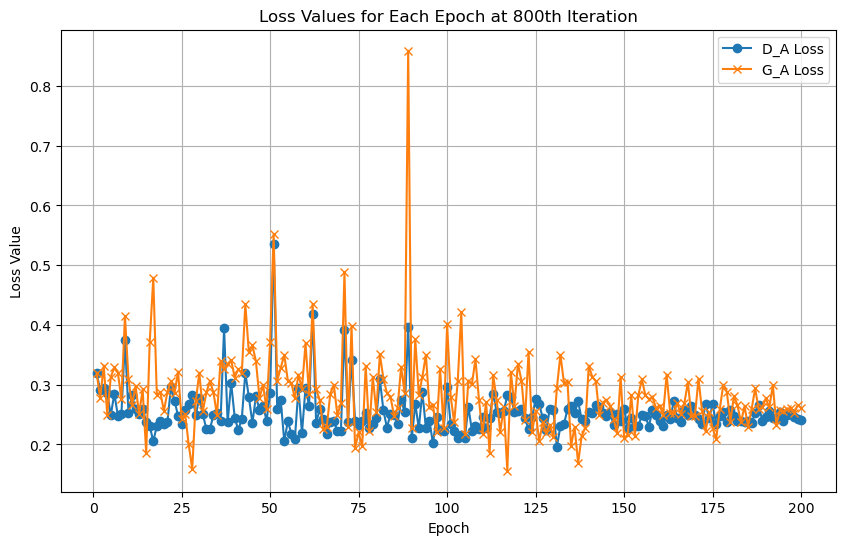

In [8]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt

#filepath to loss_log.txt
filepath = "./checkpoints/gan_signdata_ls/"

# Read in text file
with open(os.path.join(filepath, "loss_log.txt"), 'r') as file:
    text = file.read()

# Extract epoch, D_A, and G_A using regex
pattern = r"\(epoch: (\d+), iters: 800,.*?D_B: ([\d.]+) G_B: ([\d.]+)"
matches = re.findall(pattern, text)

epochs = np.array([int(match[0]) for match in matches])
D_B_values = np.array([float(match[1]) for match in matches])
G_B_values = np.array([float(match[2]) for match in matches])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, D_B_values, label='D_A Loss', marker='o')
plt.plot(epochs, G_B_values, label='G_A Loss', marker='x')
plt.title('Loss Values for Each Epoch at 800th Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/gan_signdata/test_latest/images/n02381460_1010_fake.png')
plt.imshow(img)

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/horse2zebra_pretrained/test_latest/images/n02381460_1010_real.png')
plt.imshow(img)